# Dataset preparation

This first notebook has the main goal to create one normalized dataset.
To process on training / test data, we need some adjustement and optimizations on sources images.

The final dataset path is `../dataset.hdf5` (~3Go)

In [1]:
import matplotlib.pyplot as plt # Draw images in this notebook
import os # Resolve files paths
import numpy as np # Create matrix with n dimensions
from PIL import Image # Image proccessing
import random # Shuffle data in dataset
import h5py # Save images in one dataset

## Optimizations

1) Optimize color channel:
    We doesn't need RGB channel because XRay are already in grayscale format. Pack 3 channels in 1, remove useless complexity in final matrix shape     (width, heigh, 3) -> (width, heigh, 1).

In [2]:
def rgb_to_grayscale(image):
    return image.convert('L')

2) Equalize images size:
    All images in sources aren't of same size (eg 1000 x 700, 1100 x 1000, ...).
    Our program scale images in square size. But to square rectangle image, we need to had some extra black lines
    like cinema movies.

In [3]:
def expand_to_square(image):
    width, height = image.size
    if width == height:
        return image
    elif width > height:
        result = Image.new(image.mode, (width, width), 0)
        result.paste(image, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(image.mode, (height, height), 0)
        result.paste(image, ((height - width) // 2, 0))
        return result

3) Scale image to lower resolution: 
    Reduce image dimension optimize our algorithm. With Gimp software and different training 32px image size is sufficient to recognize pneumonia

In [4]:
image_size = 32

def scale(image):
    return image.resize((image_size, image_size))

## Proccess for one image

Apply all optimization functions on one image

In [5]:
def optimize_image(image):
    image = rgb_to_grayscale(image)
    image = expand_to_square(image)
    image = scale(image)
    return image

Take on image path in parameter, load image, optimize her and use numpy to convert image into a matrix.
Matrix has 3 dimensions because in different AI librairies, images proccess use 3 dimensions (The last for the color channel).

In [6]:
def path_to_matrix(path):
    # Load image
    image = Image.open(path)
    # Apply optimization
    image = optimize_image(image)
    # Create numpy matrix
    matrix = np.asarray(image) / 255 # [0, 255] -> [0, 1]
    matrix = np.reshape(matrix, (image_size, image_size, 1)) # (w, h) -> (w, h, 1) for image matrix convention
    return matrix

Read image path to find the image classe.
There are 3 classes: 'normal' (0), 'bacteria' (1) and 'virus' (2).
Labels are shaped into 1 dimension because in different AI librairies, images can have multiple labels.

In [7]:
def path_to_label(path):
    if 'bacteria' in path:
        return [1]
    elif 'virus' in path:
        return [2]
    else:
        return [0]

## Example for one image

For example with a 1646 × 1310 image and size of 6468780 bytes (no compressed), our final image in dataset have
size of 32 x 32 and size of 1024 bytes (descreased by 6317 times).

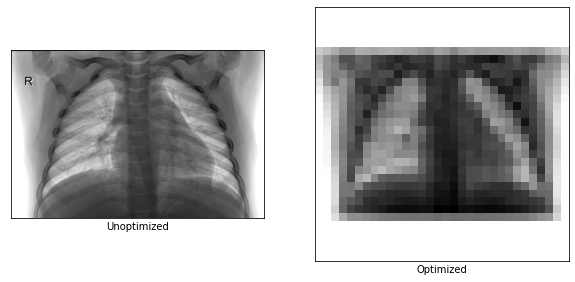

In [8]:
image_unoptimized = Image.open("../chest_Xray/train/NORMAL/IM-0127-0001.jpeg")
image_optimized = path_to_matrix("../chest_Xray/train/NORMAL/IM-0127-0001.jpeg")

# Plot theses two images
images = [image_unoptimized, image_optimized]
class_names = ['Unoptimized', 'Optimized']

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[i])
plt.show()

## Load all images of multiple directories into labels, matrix arrays 

Read one directory, load images and labels and ignore useless files

In [9]:
def load_one_directory(path):
    images = []
    labels = []
    # List all images in one directory
    for file in os.listdir(path):
        if '.jpeg' not in path + file:
            continue # Ignore other files and folder like ".DS_Store"
        matrix = path_to_matrix(path + file) # Load and convert image
        type = path_to_label(path + file) # Find the right label
        images.append(matrix) # Append in final images array
        labels.append(type) # Appen in final labels array
    return labels, images

Take multiples directories and concatenate result of call to `load_one_directory(path)`

In [10]:
def load_multiple_directories(paths):
    images = []
    labels = []
    for path in paths:
        ret_labels, ret_images = load_one_directory(path)
        labels += ret_labels
        images += ret_images
    return labels, images

Shuffle data order into arrays to avoid labels repetition in the dataset.
This will enhance training proccess

In [11]:
def shuffle_data(labels, images):
    merged = list(zip(labels, images))
    random.shuffle(merged)
    return zip(*merged)

## Dataset file generation

Create the dataset file `dataset.hdf5`, this will create subdataset `test`, `train` into the h5 file. This scope will call all previous declared function to process on images, load labels, ...

Can take more than one minute

In [12]:
path = "../dataset.hdf5"
if os.path.exists(path):
    os.unlink(path) # Delete if already exists

f = h5py.File(path, "w")

# Training subdataset
train_directories = ["../chest_Xray/train/NORMAL/", "../chest_Xray/train/PNEUMONIA/"]
labels, images = load_multiple_directories(train_directories)
labels, images = shuffle_data(labels, images)
grp = f.create_group('train')
grp.create_dataset('images', data=images)
grp.create_dataset('labels', data=labels)

# Test subdataset
test_directories = ["../chest_Xray/test/NORMAL/", "../chest_Xray/test/PNEUMONIA/"]
labels, images = load_multiple_directories(train_directories)
labels, images = shuffle_data(labels, images)
grp = f.create_group('test')
grp.create_dataset('images', data=images)
grp.create_dataset('labels', data=labels)

# Save images sizes in subdataset
shape_dts = f.create_dataset('shape', data=[image_size, image_size])

f.close()

## Test previous generated dataset

It will open the dataset file and display first 25 images with her labels in training subdataset

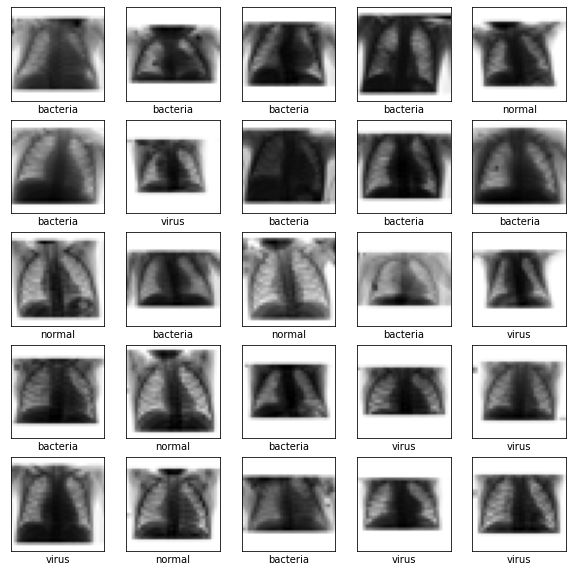

In [13]:
f = h5py.File("../dataset.hdf5", "r")

train_images = f.get('train').get('images')
train_labels = f.get('train').get('labels')

class_names = ['normal', 'bacteria', 'virus']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

f.close()